In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math,time
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct
from multiprocessing import Pool

sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (32,32,3)
num_classes = 10

In [3]:
#%%capture one
#Load model from disk
model_name = 'cifar10-resnet'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar10', transform='dct-3d',seed=SEED,project=False)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 200
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Learning rate:  0.001
Total Model Params: 273066
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

5000/5000 [==============================] - 2s 415us/step
Model Accuracy: 0.85540


In [5]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [6]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [6]:
%%capture four
#Get Regular, JSMA, DF, and CW test points

#reg_data = model.test_data[test_indices]
#start_time = time.time()
#jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='JSMA', iterations=100)
#print("--- JSMA: %s seconds ---" % (time.time() - start_time))
#start_time = time.time()
#cwl0_data = model.generate_perturbed_data(model.test_data[test_indices][0:250], seed=SEED, perturbation='CW-l0')
#print("--- CW: %s seconds ---" % (time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
#%%capture five
reg_data = np.load('data/reg_data_cifar10_l0.npy')
jsma_data = np.load('data/jsma_data_cifar10_l0.npy')
cwl0_data = np.load('data/cwl0_data_cifar10_l0.npy')


In [17]:
%%capture five
#np.save('data/reg_data_cifar10_l0', reg_data[:])
#np.save('data/jsma_data_cifar10_l0', jsma_data)
#np.save('data/cwl0_data_cifar10_l0', cwl0_data_all)

In [10]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l0: %.5f' % (model.model.evaluate(cwl0_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 219us/step
Model Accuracy REG: 0.84600
1000/1000 [==============================] - 0s 164us/step
Model Accuracy CW-l0: 0.08700
1000/1000 [==============================] - 0s 172us/step
Model Accuracy JSMA: 0.02700


Regular: 


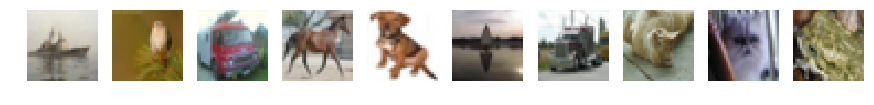

CW-l0: 


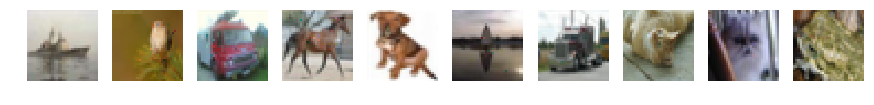

JSMA: 


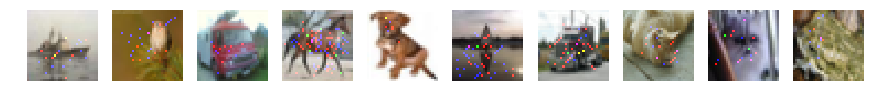

In [12]:
#Lets visualize samples from each attack
x_vis = [804 ,226, 999, 727, 537, 844, 956, 373, 322, 641]
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-cifar10_l0')
print ('CW-l0: ')
visualize(cwl0_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-cifar10_l0')
print ('JSMA: ')
visualize(jsma_data[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-cifar10_l0')

In [13]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
cwl0_preds = model.model.predict(cwl0_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
cwl0_labels = preds_to_labels(cwl0_preds)
jsma_labels = preds_to_labels(jsma_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
cwl0_idx = np.where(np.argmax(cwl0_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
cwl0_data_fil = cwl0_data[cwl0_idx]
jsma_data_fil = jsma_data[jsma_idx]


#Filter labels to be used
cwl0_labels_fil = cwl0_labels[cwl0_idx]
jsma_labels_fil = jsma_labels[jsma_idx]

In [14]:
#Get l-0 distortion 
print ('CW-l0: %.5f' % (avg_l0_dist(reg_data[cwl0_idx], cwl0_data_fil)))
print ('JSMA: %.5f' % (avg_l0_dist(reg_data[jsma_idx], jsma_data_fil)))

CW-l0: 18.00000
JSMA: 34.00000


In [15]:
#Get l-0 distortion 
print ('CW-l0: %.5f' % (avg_l2_dist(reg_data[cwl0_idx], cwl0_data_fil)))
print ('JSMA: %.5f' % (avg_l2_dist(reg_data[jsma_idx], jsma_data_fil)))

CW-l0: 0.46255
JSMA: 3.34288


In [14]:
n = 32
k=75

In [16]:
avg=0.0
ratios = []
for i,j in enumerate(cwl0_idx):
    r = np.linalg.norm(reg_data[j]-cwl0_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.01516834035240754 0.0823772 0.00011802418


In [17]:
avg=0.0
ratios = []
for i,j in enumerate(jsma_idx):
    r = np.linalg.norm(reg_data[j]-jsma_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.12120174200600013 0.59119546 0.004735911


In [19]:
n=32

In [20]:
%%capture eleven
#Reconstruct CW-l0
clean_cwl0_iht = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    x_adv_r = cwl0_data[i,:,:,0].flatten()
    x_adv_g = cwl0_data[i,:,:,1].flatten()
    x_adv_b = cwl0_data[i,:,:,2].flatten()
    t_r = len(np.where(np.abs(x_adv_r - reg_data[i,:,:,0].flatten()) > 0.0001)[0])
    t_g = len(np.where(np.abs(x_adv_g - reg_data[i,:,:,1].flatten()) > 0.0001)[0])
    t_b = len(np.where(np.abs(x_adv_b - reg_data[i,:,:,2].flatten()) > 0.0001)[0])
    x_hat_r,_ = iht(x_adv_r,t_r, T=100,k=500)
    x_hat_g,_ = iht(x_adv_g,t_g, T=100,k=500)
    x_hat_b,_ = iht(x_adv_b,t_b, T=100,k=500)
    clean_cwl0_iht[i,:,:,0]= idct(x_hat_r.flatten(),norm='ortho').reshape(n,n)
    clean_cwl0_iht[i,:,:,1]= idct(x_hat_g.flatten(),norm='ortho').reshape(n,n)
    clean_cwl0_iht[i,:,:,2]= idct(x_hat_b.flatten(),norm='ortho').reshape(n,n)

In [39]:
#%%capture twelve
#Reconstruct CW-l0
clean_jsma_iht = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv_r = jsma_data[i,:,:,0].flatten()
    x_adv_g = jsma_data[i,:,:,1].flatten()
    x_adv_b = jsma_data[i,:,:,2].flatten()
    t_r = len(np.where(np.abs(x_adv_r - reg_data[i,:,:,0].flatten()) > 0.0001)[0])
    t_g = len(np.where(np.abs(x_adv_g - reg_data[i,:,:,1].flatten()) > 0.0001)[0])
    t_b = len(np.where(np.abs(x_adv_b - reg_data[i,:,:,2].flatten()) > 0.0001)[0])
    x_hat_r,_ = iht(x_adv_r,t_r, T=100,k=500)
    x_hat_g,_ = iht(x_adv_g,t_g, T=100,k=500)
    x_hat_b,_ = iht(x_adv_b,t_b, T=100,k=500)
    clean_jsma_iht[i,:,:,0]= idct(x_hat_r.flatten(),norm='ortho').reshape(n,n)
    clean_jsma_iht[i,:,:,1]= idct(x_hat_g.flatten(),norm='ortho').reshape(n,n)
    clean_jsma_iht[i,:,:,2]= idct(x_hat_b.flatten(),norm='ortho').reshape(n,n)

In [21]:
%%capture thirteen
np.save('data/clean_cifar10_cwl0_l0-iht', clean_cwl0_iht)
np.save('data/clean_cifar10_jsma_l0-iht', clean_jsma_iht)

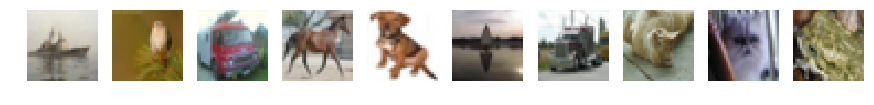

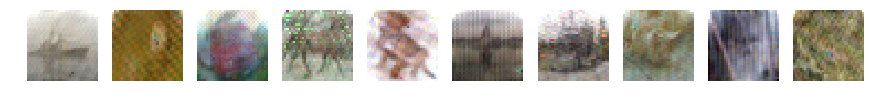

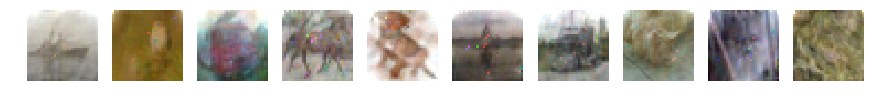

In [24]:
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-cifar10_l0')
visualize(clean_cwl0_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-clean-cifar10_l0-iht')
visualize(clean_jsma_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-clean-cifar10_l0-iht')

In [25]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_cwl0_iht,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed JSMA: %.5f' % (model.model.evaluate(clean_jsma_iht,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 219us/step
Model Accuracy Reconstructed CW-l0: 0.40300
1000/1000 [==============================] - 0s 184us/step
Model Accuracy Reconstructed JSMA: 0.53100


In [26]:
D = get_matrix(n*n)
A = np.concatenate((D.T,np.identity(n*n)),axis=1)

In [27]:
clean_r,clean_g,clean_b = [],[],[]
args_r,args_g,args_b =[],[],[] 

In [28]:
def clean_sample(a):
    x_adv, n, eta = a
    x_hat = socp(x_adv.flatten(),A,n=n,eta=eta)[:n]
    return x_hat

In [29]:
avg_r,avg_g,avg_b=0.0,0.0,0.0
for i in range(num_test_samples):
    _,x_bot_r= get_top_bot_k_vec(reg_data[i,:,:,0].flatten(),k=1000)
    _,x_bot_g= get_top_bot_k_vec(reg_data[i,:,:,1].flatten(),k=1000)
    _,x_bot_b= get_top_bot_k_vec(reg_data[i,:,:,2].flatten(),k=1000)
    avg_r+=np.linalg.norm(x_bot_r)
    avg_g+=np.linalg.norm(x_bot_g)
    avg_b+=np.linalg.norm(x_bot_b)

print(avg_r/float(num_test_samples), avg_g/float(num_test_samples),avg_b/float(num_test_samples),)

0.5943346510772245 0.5761962626140298 0.4997660166254397


In [30]:
for i in range(num_test_samples):
    args_r.append( (cwl0_data[i,:,:,0],2*n*n,0.5943346510772245))
    args_g.append( (cwl0_data[i,:,:,1],2*n*n,0.5761962626140298))
    args_b.append( (cwl0_data[i,:,:,2],2*n*n,0.4997660166254397))

In [31]:
my_args = [args_r, args_g, args_b]
my_clean = [clean_r, clean_g, clean_b]

In [33]:
%%capture pooling1
p = Pool(100)
st = time.time()
my_clean[0] = p.map(clean_sample, args_r)
print(time.time() - st)
p.terminate()

In [34]:
%%capture pooling2
p = Pool(100)
st = time.time()
my_clean[1] = p.map(clean_sample, args_g)
print(time.time() - st)
p.terminate()

In [ ]:
%%capture pooling3
p = Pool(100)
st = time.time()
my_clean[2] = p.map(clean_sample, args_b)
print(time.time() - st)
p.terminate()

In [ ]:
%%capture collecting
clean_cwl0 = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    clean_cwl0[i,:,:,0] = idct(my_clean[0][i].flatten()[:n*n],norm='ortho').reshape(n,n)
    clean_cwl0[i,:,:,1] = idct(my_clean[1][i].flatten()[:n*n],norm='ortho').reshape(n,n)
    clean_cwl0[i,:,:,2] = idct(my_clean[2][i].flatten()[:n*n],norm='ortho').reshape(n,n)

In [ ]:
%%capture saving
np.save('data/clean_cifar10_cwl0_l0-socp', clean_cwl0)

In [ ]:
clean_jsma= np.load('data/clean_cifar10_jsma_l0-socp.npy')

In [41]:
print ('Model Accuracy Reconstructed CWl0: %.5f' % (model.model.evaluate(clean_cwl0,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed JSMA: %.5f' % (model.model.evaluate(clean_jsma,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 224us/step
Model Accuracy Reconstructed CWl0: 0.67000
1000/1000 [==============================] - 0s 182us/step
Model Accuracy Reconstructed JSMA: 0.67300


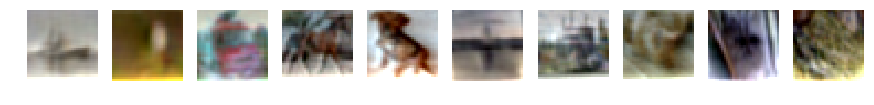

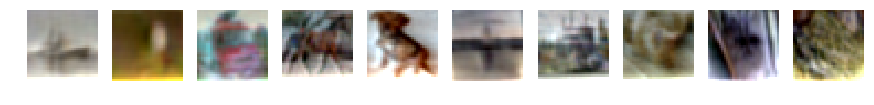

In [42]:
visualize(clean_cwl0[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-clean-cifar10_l0-socp')
visualize(clean_jsma[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-clean-cifar10_l0-socp')